In [1]:
%load_ext autoreload
%autoreload 2

%load_ext line_profiler

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pickle

from chemistry import Molecule
from util import score
from pprint import pprint

In [3]:
with open('../data/molecules.pickle', 'rb') as f:
    molecules = pickle.load(f)

In [4]:
structures = pd.read_feather('../data/structures.feather')
labelled = pd.read_feather('../data/train.feather')
unlabelled = pd.read_feather('../data/test.feather')

In [5]:
types = labelled.type.unique()
atoms = structures.atom.unique()

index = 0
type_index = {}
for t in types:
    type_index[t] = index
    index += 1

index = 0
atom_index = {}
for a in atoms:
    atom_index[a] = index
    index += 1

In [6]:
def partition_labelled(data, count=None, train_frac=0.7):
    n_labelled = count if count is not None else len(labelled)
    n_train = int(n_labelled * train_frac)
    n_test = n_labelled - n_train
    indices = np.arange(0, n_labelled)
    np.random.shuffle(indices)
    
    train_indices = indices[0:n_train]
    test_indices = indices[n_train:]
    
    train = data.iloc[train_indices, :]
    test = data.iloc[test_indices, :]

    return train, test

def make_input(data):
    n = len(data)
    

    coupling_input = np.zeros((len(types), n), dtype='float32')
    atom_input = [None] * 4
    for i in range(len(atom_input)):
        atom_input[i] = np.zeros((len(atoms), n), dtype='float32')

    bond_input = [None] * 3
    for i in range(len(bond_input)):
        bond_input[i] = np.zeros((3, n), dtype='float32')

    for t in type_index:
        coupling_input[type_index[t], data.type == t] = 1

    for i, row in enumerate(data.itertuples()):
        # coupling_input[type_index[row.type], i] = 1
        
        m = molecules[row.molecule_name]
        bonds = m.bonds
        
        path = m.compute_path(row.atom_index_0, row.atom_index_1)
        syms = [m.symbols[idx] for idx in path]
        
        atom_input[0][atom_index[syms[0]], i]  = 1
        
        try:
            i0 = path[0]
            for j, i1 in enumerate(path[1:]):
                b = bonds.get((i0, i1), None)
                if b is None:
                    b = bonds.get((i1, i0), None)
                if b is None:
                    print(f'Unable to resolve bond - path = {path}, bond = {(i0, i1)})')
                    i0 = i1
                    continue

                j2 = j + 1

                bond_input[j][:, i] = [b.dist, b.valency, b.strength]            
                atom_input[j2][atom_index[syms[j2]], i] = 1

                i0 = i1
        except:
            pass
            
    return (coupling_input, atom_input, bond_input)

def make_output(data):
    n = len(data)
    output = np.zeros(n, dtype='float32')
    #output[:] = data.norm_scc
    output[:] = data.scalar_coupling_constant
        
    return output

def combine_inputs(inputs_tuple):
    coupling_input, atom_input, bond_input = inputs_tuple
    
    inputs = [coupling_input]
    inputs.extend(atom_input)
    inputs.extend(bond_input)
    
    w, h = coupling_input.shape
    for a in atom_input:
        w += a.shape[0]
    for a in bond_input:
        w += a.shape[0]
    
    input = np.empty((w, h), dtype='float32')
    i = 0
    for a in inputs:
        w, _ = a.shape
        input[i:i + w, :] = a
        i += w
    
    return input.T

In [19]:
data = labelled.sample(1000)
coupling_input, atom_inputs, bond_inputs = make_input(data)

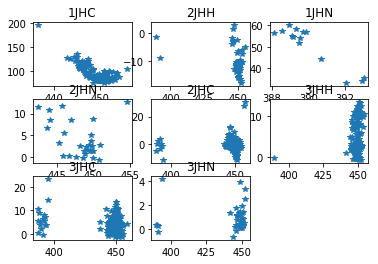

In [42]:
plt.figure()
for i, t in enumerate(types, 1):
    sel = data.type == t
    
    plt.subplot(3, 3, i)
    plt.plot(bond_inputs[0][0, sel] * bond_inputs[0][2, sel], data[sel].scalar_coupling_constant, '*')
    plt.title(t)

plt.show()